0:	learn: 2.4476391	total: 1.81ms	remaining: 2.72s
1:	learn: 1.6409572	total: 3.48ms	remaining: 2.6s
2:	learn: 1.4992066	total: 4.88ms	remaining: 2.43s
3:	learn: 1.4484056	total: 6.34ms	remaining: 2.37s
4:	learn: 1.4076761	total: 7.8ms	remaining: 2.33s
5:	learn: 1.3906166	total: 9.31ms	remaining: 2.32s
6:	learn: 1.3786162	total: 10.7ms	remaining: 2.28s
7:	learn: 1.3576768	total: 12.2ms	remaining: 2.28s
8:	learn: 1.3500691	total: 13.7ms	remaining: 2.27s
9:	learn: 1.3451834	total: 15.1ms	remaining: 2.24s
10:	learn: 1.3375455	total: 16.6ms	remaining: 2.24s
11:	learn: 1.3299851	total: 17.9ms	remaining: 2.22s
12:	learn: 1.3236886	total: 19.4ms	remaining: 2.21s
13:	learn: 1.3161980	total: 20.8ms	remaining: 2.2s
14:	learn: 1.3118653	total: 22.2ms	remaining: 2.2s
15:	learn: 1.3066299	total: 23.7ms	remaining: 2.19s
16:	learn: 1.3029091	total: 25.2ms	remaining: 2.19s
17:	learn: 1.2997921	total: 26.6ms	remaining: 2.19s
18:	learn: 1.2960910	total: 28.1ms	remaining: 2.19s
19:	learn: 1.2914548	total

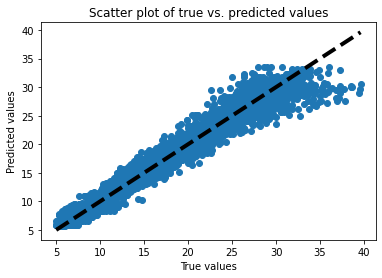

Training set:
R2: 0.9706759198827183
NSE: 0.9706759198827183
RMSE: 0.9364778637609055
MAE: 0.6527012588201605

Testing set:
R2: 0.9638057152826034
NSE: 0.9638057152826034
RMSE: 1.0441295665693673
MAE: 0.7114040802345019


In [2]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# Load and preprocess the dataset
data = pd.read_csv('CanopyTempWeatherSC.csv')

data['CanopyTemp'] = data['CanopyTemp'].astype(float)
data_filtered = data[(data['CanopyTemp'] >= 5) & (data['CanopyTemp'] <= 40)]

X = data_filtered.iloc[:, [6,7]].values

# Perform scaling on the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = data_filtered.iloc[:, 4].values 
y = y.reshape(-1, 1)
y = np.ravel(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define the CatBoost model
model = CatBoostRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [1500],
    'depth': [5],
    'learning_rate': [0.7],
    'loss_function': ['RMSE'],
}

# Perform cross-validation using GridSearchCV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_model = GridSearchCV(model, param_grid, cv=kfold, scoring='neg_mean_squared_error')
cv_model.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", cv_model.best_params_)

# Train the final model with the best hyperparameters
final_model = CatBoostRegressor(**cv_model.best_params_)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

T4SCSM1_CB = pd.DataFrame({'Measured': y_test.flatten(), 'Estimated': y_pred.flatten()})

# Save the DataFrame to a file
T4SCSM1_CB.to_csv('SCSM12_CB.csv', index=False)

plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of true vs. predicted values')

# add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# show the plot
plt.show()

y_train_pred = final_model.predict(X_train)
y_train = y_train.reshape(-1)
y_train_pred = y_train_pred.reshape(-1)
mean_y_train = y_train.mean()
y_train_mean = np.repeat(y_train.mean(), y_train.shape[0])

train_r2 = r2_score(y_train, y_train_pred)
train_nse = 1 - mean_squared_error(y_train, y_train_pred)/mean_squared_error(y_train, y_train_mean)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Training set:")
print("R2:", train_r2)
print("NSE:", train_nse)
print("RMSE:", train_rmse)
print("MAE:", train_mae)
print()

metricstrain = [
    {'Metric': 'RMSE', 'Value': train_rmse},
    {'Metric': 'R2', 'Value': train_r2},
    {'Metric': 'NSE', 'Value': train_nse},
    {'Metric': 'MAE', 'Value': train_mae}
]

df = pd.DataFrame(metricstrain)
df.to_csv('CBSC_trainmetrics.csv', index=False)

y_test_pred = final_model.predict(X_test)
y_test = y_test.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)
mean_y_test = y_test.mean()
y_test_mean = np.repeat(y_test.mean(), y_test.shape[0])

test_r2 = r2_score(y_test, y_test_pred)
test_nse = 1 - mean_squared_error(y_test, y_test_pred)/mean_squared_error(y_test, y_test_mean)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Testing set:")
print("R2:", test_r2)
print("NSE:", test_nse)
print("RMSE:", test_rmse)
print("MAE:", test_mae)

metricstest = [
    {'Metric': 'RMSE', 'Value': test_rmse},
    {'Metric': 'R2', 'Value': test_r2},
    {'Metric': 'NSE', 'Value': test_nse},
    {'Metric': 'MAE', 'Value': test_mae}
]

df = pd.DataFrame(metricstest)
df.to_csv('CBSC_testmetrics.csv', index=False)
